In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Jul  4 15:11:12 2020

@author: jiajia

Do wavelet analysis and show result

Revised from https://github.com/chris-torrence/wavelets/tree/master/wave_python
"""
import numpy as np
from waveletFunction import wavelet, wave_signif
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [72]:
def do_wavelet(sst, dt, time=None, unit='Year', fig_name=None, num=50,
               title='Signal', ylabel='Variation', cmap='Purples', 
               show_peaks=True, fill_nan=True, idx=None, fontsize=15, **kwargs):
    '''
    sst: equal-grid time series of data
    dt: time difference between two points
    time: time series, default is 'Year'
    unit: unit of time
    fig_name: path to save figure, if None, no figure will be saved
    num: number of window to show the image, default is 50
    cmap: color map name used to show the wavelet spectrum
    show_peaks: if set, peaks of the global spectrum will be found and shown
    fill_nan: if set, nan/inf will be replace with the average value of its
              previous and next points
    '''
    plt.rcParams['font.size'] = '15'
    # Preprocess data
    if fill_nan:
        mask = np.isnan(sst)
        sst[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), sst[~mask])
    sst = sst - np.mean(sst)
    variance = np.std(sst, ddof=1) ** 2
    print("Data variance = ", variance)

    #----------C-O-M-P-U-T-A-T-I-O-N------S-T-A-R-T-S------H-E-R-E------------------------------------------------------

    n = len(sst)
    if time is None:
        time = np.arange(len(sst)) * dt

    # Wavelet transform:
    wave, period, scale, coi = wavelet(sst, dt, **kwargs)
    power = (np.abs(wave)) ** 2  # compute wavelet power spectrum
    global_ws = (np.sum(power, axis=1) / n)  # time-average over all times

    # Significance levels:
    signif = wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,
        **kwargs)
    sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])  # expand signif --> (J+1)x(N) array
    sig95 = power / sig95  # where ratio > 1, power is significant

    # Global wavelet spectrum & significance levels:
    dof = n - scale  # the -scale corrects for padding at edges
    global_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=1,
        dof=dof, **kwargs)
    global_signif95 = None
    if 'siglvl' in kwargs:
        if kwargs.get('siglvl') != 0.95:
            kwargs2 = dict(kwargs)
            kwargs2.pop('siglvl')
            global_signif95 = wave_signif(variance, dt=dt, scale=scale, sigtest=1,
                                          dof=dof, siglvl=0.95, **kwargs2)

    #------------------------------------------------------ Plotting

    #--- Plot time series
    fig = plt.figure(num, figsize=(12, 8))
    gs = GridSpec(2, 4, wspace=0.2)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.95, wspace=0, hspace=0.3)
    plt.subplot(gs[0, 0:4])
    plt.plot(time, sst, 'k')

    if unit:
        plt.xlabel('Time (' + unit + ')')
    else:
        plt.xlabel('Time')


    plt.ylabel(ylabel)
    plt.title('a) ' + title)
    plt.xlim([time[0], time[-1]])
    ylim = plt.gca().get_ylim()
    if idx is not None:
        plt.plot([time[idx], time[idx]], ylim, 'k--', linewidth=2)
    plt.ylim(ylim)

    #--- Contour plot wavelet power spectrum
    # plt3 = plt.subplot(3, 1, 2)
    plt3 = plt.subplot(gs[1, 0:3])
    #levels = [0, 0.5, 1, 2, 4, 999]
    CS = plt.contourf(time, period, power, cmap=cmap)  #*** or use 'contour'
    #im = plt.contourf(CS, levels=levels, colors=['white','bisque','orange','orangered','darkred'])
    
    if unit :
        plt.xlabel('Time (' + unit + ')')
        plt.ylabel('Period (' + unit + ')')
    else:
        plt.xlabel('Time')
        plt.ylabel('Period (Day)')


    plt.title('b) Wavelet Power Spectrum')
    # 95# significance contour, levels at -99 (fake) and 1 (95# signif)
    plt.contour(time, period, sig95, [-99, 1], colors='black')
    # cone-of-influence, anything "below" is dubious
    # plt.plot(time, coi, 'orange')
    plt.fill_between(time, coi,np.max(period), color='gray',alpha=0.2, zorder=10, hatch='x')
    # format y-scale
    plt3.set_yscale('log', base=2, subs=None)
    plt.ylim([np.min(period), np.max(period)])
    ax = plt.gca().yaxis
    ax.set_major_formatter(ticker.ScalarFormatter())
    plt3.ticklabel_format(axis='y', style='plain')
    #plt3.invert_yaxis()
    # set up the size and location of the colorbar
    #position=fig.add_axes([0.02,0.095,0.02,0.85])
    #plt.colorbar(CS, cax=position, orientation='vertical') #, fraction=0.05, pad=0.5)

    # plt.subplots_adjust(right=0.7, top=0.9)

    #--- Plot global wavelet spectrum
    period_back = np.copy(period)
    global_ws_back = np.copy(global_ws)
    global_signif_back = np.copy(global_signif)
    period = np.arange(np.min(period), np.max(period), 0.02)
    global_ws = np.interp(period, period_back, global_ws_back)
    global_signif = np.interp(period, period_back, global_signif_back)
    print(len(period), len(global_ws), len(global_signif))


    # find out peaks
    periods = []
    peaks = []
    idx = []
    for i in np.arange(2, len(global_ws)-3):
        if ((global_ws[i] == np.max(global_ws[i-2:i+3])) |
            (global_ws[i] == np.max(global_ws[i-2:i+3]))) & \
            (global_ws[i] > global_signif[i]):
                peaks.append(global_ws[i])
                periods.append(period[i])
                idx.append(i)
    # find out start and end of every peak
    nperiods = len(periods)
    starts = np.zeros(nperiods)
    ends = np.zeros(nperiods)

    for i in range(nperiods):
        if idx[i] <= 2:
            s = 1
        for j in np.arange(idx[i], 2, -1):
            s = j
            if (global_ws[j] >= global_signif[j]) & \
                (not ((global_ws[j] == np.min(global_ws[j-2:j+3])) |
                     (global_ws[j] == np.min(global_ws[j-2:j+3])))):
                      pass
            else:
                break
        starts[i] = period[s]
        if idx[i] >= len(global_ws)-3:
            s = len(global_ws)-2
        for j in np.arange(idx[i], len(global_ws)-3, 1):
            s = j
            if (global_ws[j] >= global_signif[j]) & \
                (not ((global_ws[j] == np.min(global_ws[j-2:j+3])) |
                     (global_ws[j] == np.min(global_ws[j-2:j+3])))):
                  pass
            else:
                break
        ends[i] = period[s]

    plt4 = plt.subplot(gs[1, -1])
    plt.plot(global_ws, period, c='black')
    plt.plot(global_signif, period, '--', c='black')
    if global_signif95 is not None:
        plt.plot(global_signif95, period, c='black', linestyle='dashdot')
    plt.xlabel('Power')
    plt.title('c) Global Spectrum')
    plt.xlim([0, 1.25 * np.max(global_ws)])
    if show_peaks:
        for i in range(len(peaks)):
            plt.annotate('{:.1f}'.format(periods[i]), xy=(peaks[i], periods[i]),
                         xycoords='data', c='purple', size=12)
            plt.plot([0, 1.25 * np.max(global_ws)], [starts[i], starts[i]],
                     linestyle=':', c='black')
            plt.plot([0, 1.25 * np.max(global_ws)], [ends[i], ends[i]],
                     linestyle=':', c='black')
    # format y-scale
    plt4.set_yscale('log', base=2, subs=None)
    plt.ylim([np.min(period), np.max(period)])
    ax = plt.gca().yaxis
    ax.set_major_formatter(ticker.ScalarFormatter())
    plt4.ticklabel_format(axis='y', style='plain')
    #plt4.invert_yaxis()
    ax.set_ticklabels([])
    plt.tight_layout()


    # plt.show()
    # CLOSE fig

    if fig_name is not None:
        fig.savefig(fig_name, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()
    
    return(periods, starts, ends)

# Util

In [3]:
import numpy as np

In [65]:
import pandas as pd
import do_wavelet  # Import the module itself, not a function or class from the module
import importlib

# Now reload the module correctly
importlib.reload(do_wavelet)

<module 'do_wavelet' from 'd:\\py_repo\\EVE-spectrum-correction\\Chapter4_v3\\basic_ops\\eve_ops\\do_wavelet.py'>

Data variance =  0.5007077728736138
wave shape:  (24, 108)
period shape:  (24,)
scale shape:  (24,)
coi shape:  (108,)


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


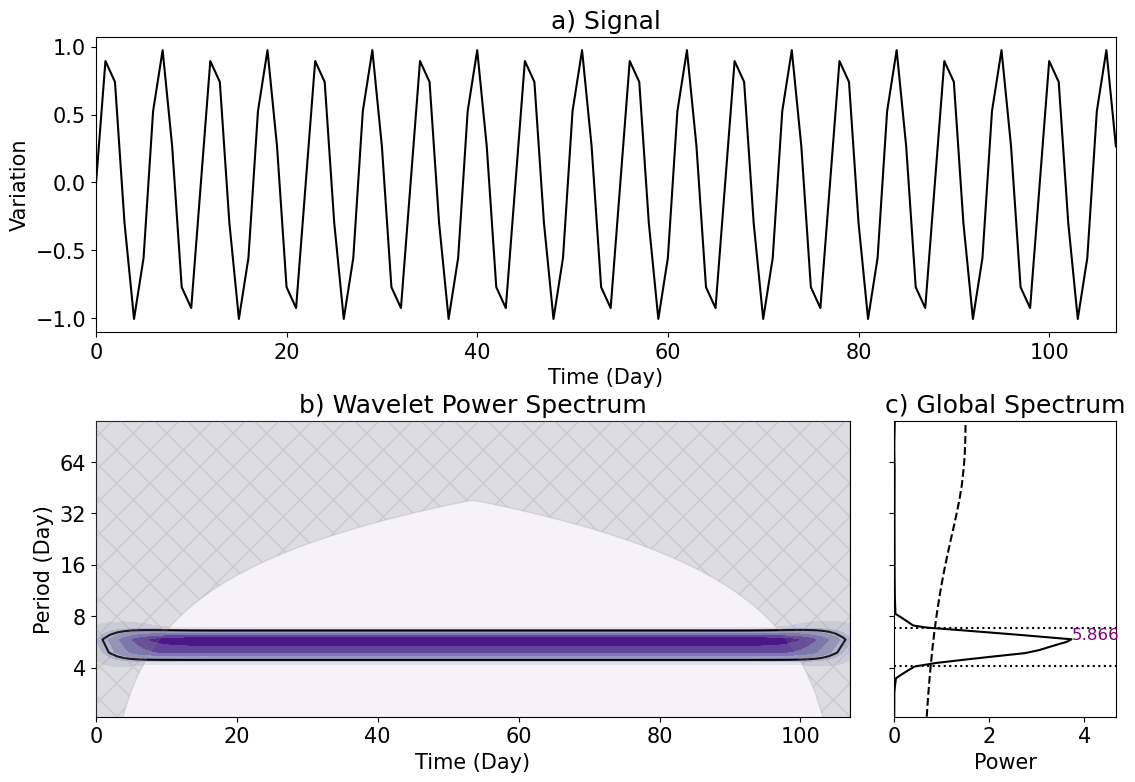

([5.866087295498511], array([4.0660873]), array([6.8660873]))

In [66]:
length= 108
# time=pd.date_range(start='1/1/2014', periods=length, freq='D')
# sst=np.sin(np.linspace(0, 2*np.pi, length)*2*np.pi/10) # +np.random.randn(length)*0.1

time=np.arange(0,length)
sst=np.sin(time*2*np.pi/5.5) # +np.random.randn(length)*0.1


do_wavelet.do_wavelet(
            sst, 1, 
        #    time=time, 

           unit='Day',  num=50)

Data variance =  0.5049999999999997


ValueError: operands could not be broadcast together with shapes (101,) (102,) 

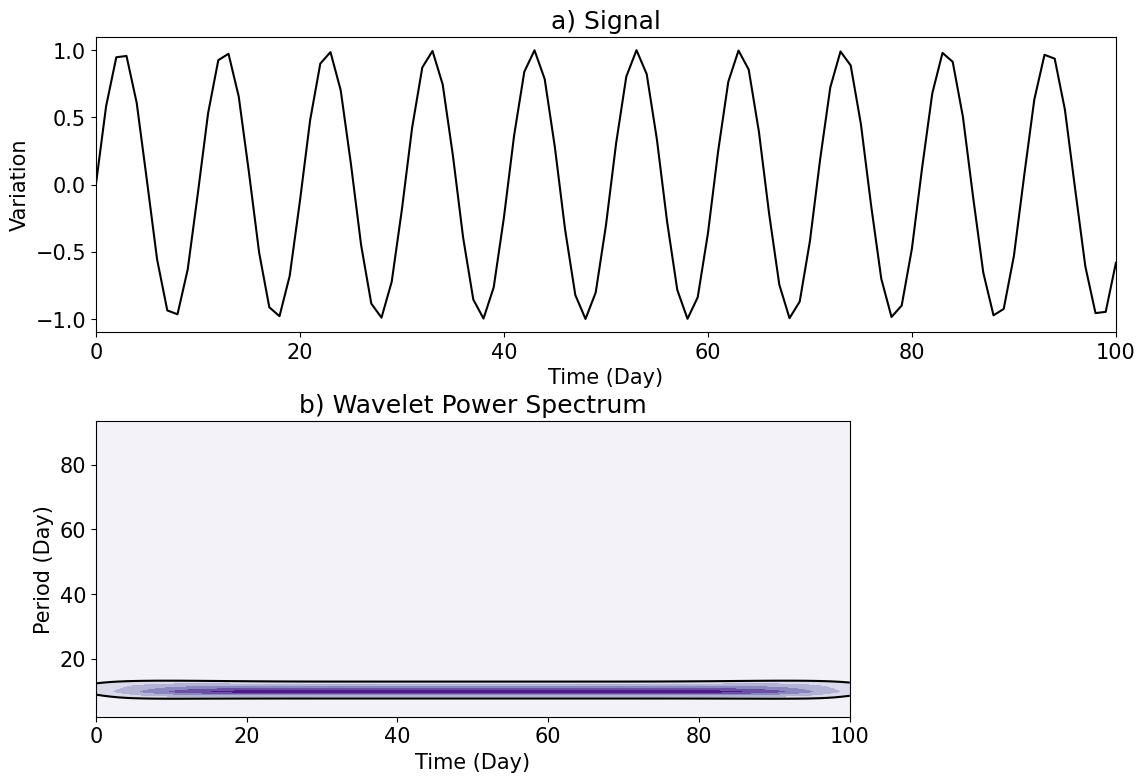

In [27]:
length= 101
time=pd.date_range(start='1/1/2014', periods=length, freq='D')
sst=np.sin(np.arange(length)*2*np.pi/(length*10**(-1)))


do_wavelet(
            sst, 1, 
        #    time=time, 
           unit='Day',  num=50)

# Test why 100 error but 365 correct

In [29]:
import pandas as pd
length= 100

In [63]:
sst=np.sin(np.arange(length)*2*np.pi/(length*10**(-1)))
sst

array([ 0.00000000e+00,  5.87785252e-01,  9.51056516e-01,  9.51056516e-01,
        5.87785252e-01,  1.22464680e-16, -5.87785252e-01, -9.51056516e-01,
       -9.51056516e-01, -5.87785252e-01, -2.44929360e-16,  5.87785252e-01,
        9.51056516e-01,  9.51056516e-01,  5.87785252e-01,  3.67394040e-16,
       -5.87785252e-01, -9.51056516e-01, -9.51056516e-01, -5.87785252e-01,
       -4.89858720e-16,  5.87785252e-01,  9.51056516e-01,  9.51056516e-01,
        5.87785252e-01,  6.12323400e-16, -5.87785252e-01, -9.51056516e-01,
       -9.51056516e-01, -5.87785252e-01, -7.34788079e-16,  5.87785252e-01,
        9.51056516e-01,  9.51056516e-01,  5.87785252e-01,  8.57252759e-16,
       -5.87785252e-01, -9.51056516e-01, -9.51056516e-01, -5.87785252e-01,
       -9.79717439e-16,  5.87785252e-01,  9.51056516e-01,  9.51056516e-01,
        5.87785252e-01,  1.10218212e-15, -5.87785252e-01, -9.51056516e-01,
       -9.51056516e-01, -5.87785252e-01, -1.22464680e-15,  5.87785252e-01,
        9.51056516e-01,  

In [66]:
sst=np.sin(np.arange(length)*2*np.pi/(length*10**(-1))), 
dt=1,
time=pd.date_range(start='1/1/2014', periods=length, freq='D'),
unit='Year', 
fig_name=None, 
num=50,
               
title='Signal', 
ylabel='Variation', 
cmap='Purples', 
show_peaks=True, 
fill_nan=True, 
idx=None, 
fontsize=15,

In [67]:
sst=np.sin(np.arange(length)*2*np.pi/(length*10**(-1)))
dt=1
time=pd.date_range(start='1/1/2014', periods=length, freq='D')
unit='Year'
fig_name=None
num=50

title='Signal'
ylabel='Variation'
cmap='Purples'
show_peaks=True
fill_nan=True
idx=None
fontsize=15
kwargs={}

In [68]:
plt.rcParams['font.size'] = '15'
# Preprocess data
if fill_nan:
    mask = np.isnan(sst)
    sst[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), sst[~mask])


In [69]:
sst = sst - np.mean(sst)
variance = np.std(sst, ddof=1) ** 2
print("Data variance = ", variance)

Data variance =  0.5050505050505049


In [70]:
#----------C-O-M-P-U-T-A-T-I-O-N------S-T-A-R-T-S------H-E-R-E------------------------------------------------------

n = len(sst)
if time is None:
    time = np.arange(len(sst)) * dt

# Wavelet transform:
wave, period, scale, coi = wavelet(sst, dt, **kwargs)
power = (np.abs(wave)) ** 2  # compute wavelet power spectrum
global_ws = (np.sum(power, axis=1) / n)  # time-average over all times

# Significance levels:
signif = wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,
    **kwargs)
sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])  # expand signif --> (J+1)x(N) array
sig95 = power / sig95  # where ratio > 1, power is significant

# Global wavelet spectrum & significance levels:
dof = n - scale  # the -scale corrects for padding at edges
global_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=1,
    dof=dof, **kwargs)
global_signif95 = None
if 'siglvl' in kwargs:
    if kwargs.get('siglvl') != 0.95:
        kwargs2 = dict(kwargs)
        kwargs2.pop('siglvl')
        global_signif95 = wave_signif(variance, dt=dt, scale=scale, sigtest=1,
                                        dof=dof, siglvl=0.95, **kwargs2)

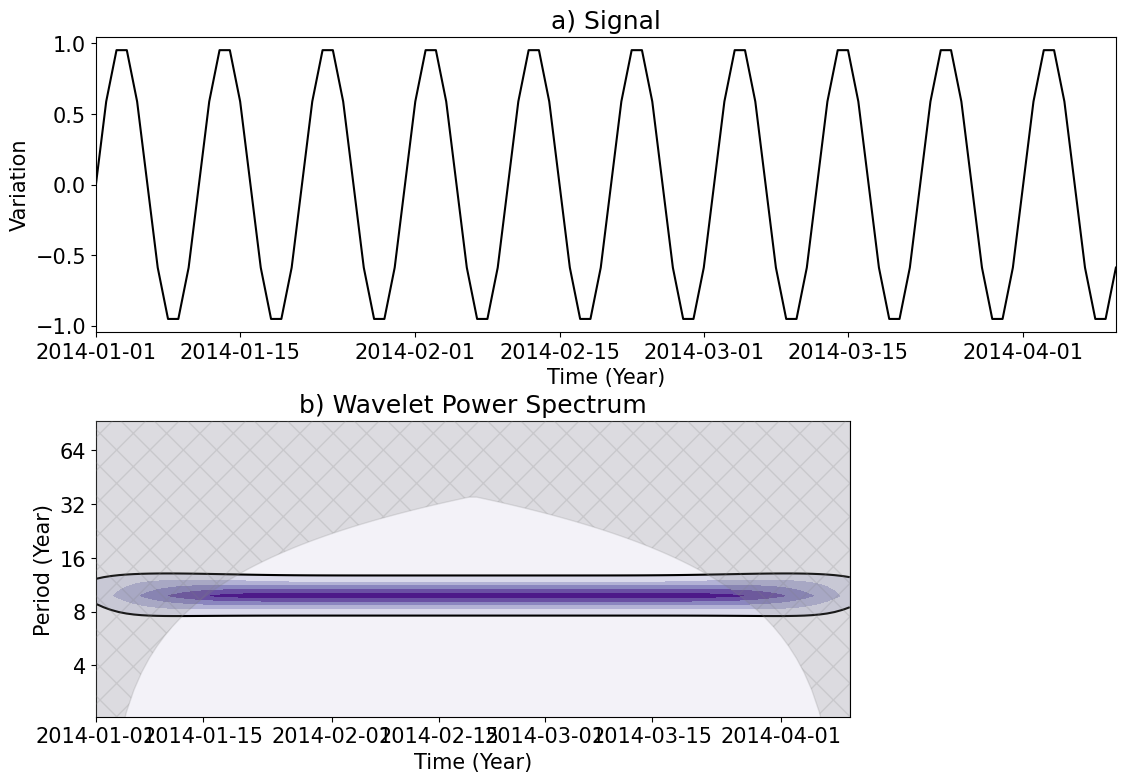

In [71]:
#------------------------------------------------------ Plotting

#--- Plot time series
fig = plt.figure(num, figsize=(12, 8))
gs = GridSpec(2, 4, wspace=0.2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.95, wspace=0, hspace=0.3)
plt.subplot(gs[0, 0:4])
plt.plot(time, sst, 'k')

if unit:
    plt.xlabel('Time (' + unit + ')')
else:
    plt.xlabel('Time')


plt.ylabel(ylabel)
plt.title('a) ' + title)
plt.xlim([time[0], time[-1]])
ylim = plt.gca().get_ylim()
if idx is not None:
    plt.plot([time[idx], time[idx]], ylim, 'k--', linewidth=2)
plt.ylim(ylim)

#--- Contour plot wavelet power spectrum
# plt3 = plt.subplot(3, 1, 2)
plt3 = plt.subplot(gs[1, 0:3])
#levels = [0, 0.5, 1, 2, 4, 999]
CS = plt.contourf(time, period, power, cmap=cmap)  #*** or use 'contour'
#im = plt.contourf(CS, levels=levels, colors=['white','bisque','orange','orangered','darkred'])

if unit :
    plt.xlabel('Time (' + unit + ')')
    plt.ylabel('Period (' + unit + ')')
else:
    plt.xlabel('Time')
    plt.ylabel('Period (Day)')


plt.title('b) Wavelet Power Spectrum')
# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
plt.contour(time, period, sig95, [-99, 1], colors='black')
# cone-of-influence, anything "below" is dubious
# plt.plot(time, coi, 'orange')
plt.fill_between(time, coi,np.max(period), color='gray',alpha=0.2, zorder=10, hatch='x')
# format y-scale
plt3.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt3.ticklabel_format(axis='y', style='plain')
#plt3.invert_yaxis()
# set up the size and location of the colorbar
#position=fig.add_axes([0.02,0.095,0.02,0.85])
#plt.colorbar(CS, cax=position, orientation='vertical') #, fraction=0.05, pad=0.5)

# plt.subplots_adjust(right=0.7, top=0.9)

#--- Plot global wavelet spectrum
period_back = np.copy(period)
global_ws_back = np.copy(global_ws)
global_signif_back = np.copy(global_signif)
period = np.arange(np.min(period), np.max(period), 0.022)
global_ws = np.interp(period, period_back, global_ws_back)
global_signif = np.interp(period, period_back, global_signif_back)


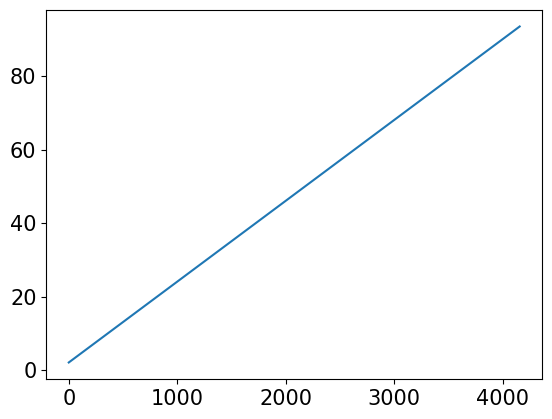

In [45]:
plt.plot(period)

In [37]:
# find out peaks
periods = []
peaks = []
idx = []
for i in np.arange(2, len(global_ws)-3):
    if ((global_ws[i] == np.max(global_ws[i-2:i+3])) |
        (global_ws[i] == np.max(global_ws[i-2:i+3]))) & \
        (global_ws[i] > global_signif[i]):
            peaks.append(global_ws[i])
            periods.append(period[i])
            idx.append(i)
# find out start and end of every peak
nperiods = len(periods)
starts = np.zeros(nperiods)
ends = np.zeros(nperiods)

for i in range(nperiods):
    if idx[i] <= 2:
        s = 1
    for j in np.arange(idx[i], 2, -1):
        s = j
        if (global_ws[j] >= global_signif[j]) & \
            (not ((global_ws[j] == np.min(global_ws[j-2:j+3])) |
                    (global_ws[j] == np.min(global_ws[j-2:j+3])))):
                    pass
        else:
            break
    starts[i] = period[s]
    if idx[i] >= len(global_ws)-3:
        s = len(global_ws)-2
    for j in np.arange(idx[i], len(global_ws)-3, 1):
        s = j
        if (global_ws[j] >= global_signif[j]) & \
            (not ((global_ws[j] == np.min(global_ws[j-2:j+3])) |
                    (global_ws[j] == np.min(global_ws[j-2:j+3])))):
                pass
        else:
            break
    ends[i] = period[s]


In [ ]:
from gaussian_fit_eve import gaussian_fit_eve

In [80]:
period[i-2:i+3]

array([], dtype=float64)

In [87]:
i=6

intial_guess = [np.max(global_ws[i-2:i+3]),period[i],period[i]-period[i-1]]
gaussian_fit_eve(period[i-2:i+3],global_ws[i-2:i+3],initial_guess=intial_guess)

(array([nan, nan, nan]),
 array([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]))

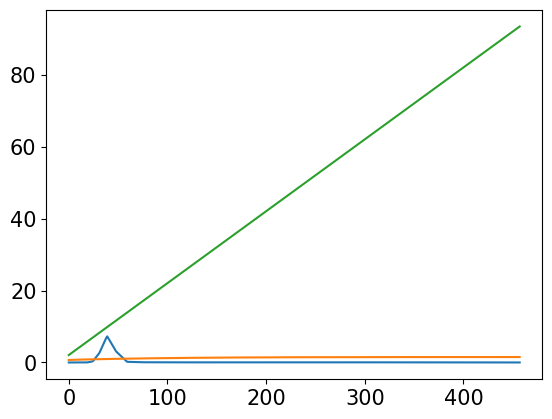

C:\Users\14902\AppData\Local\Temp\ipykernel_23680\1973178011.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


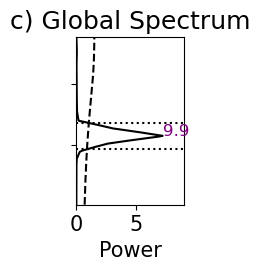

In [47]:
plt4 = plt.subplot(gs[1, -1])
plt.plot(global_ws, period, c='black')
plt.plot(global_signif, period, '--', c='black')
if global_signif95 is not None:
    plt.plot(global_signif95, period, c='black', linestyle='dashdot')
plt.xlabel('Power')
plt.title('c) Global Spectrum')
plt.xlim([0, 1.25 * np.max(global_ws)])
if show_peaks:
    for i in range(len(peaks)):
        plt.annotate('{:.1f}'.format(periods[i]), xy=(peaks[i], periods[i]),
                        xycoords='data', c='purple', size=12)
        plt.plot([0, 1.25 * np.max(global_ws)], [starts[i], starts[i]],
                    linestyle=':', c='black')
        plt.plot([0, 1.25 * np.max(global_ws)], [ends[i], ends[i]],
                    linestyle=':', c='black')
# format y-scale
plt4.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')
#plt4.invert_yaxis()
ax.set_ticklabels([])
plt.tight_layout()


# plt.show()
# CLOSE fig

if fig_name is not None:
    fig.savefig(fig_name, bbox_inches='tight')
    plt.close(fig)
else:
    plt.show()

# return(periods, starts, ends)